In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [1]:
# import my modules for reading dataframes from folder /hrdtools

import sys

sys.path.insert(0, '../')

from hrdtools.segments_data_processor import SegmentsDataProcessor, SegmentsDataProcessor2
from hrdtools.lengths_data_processor import process_lengths_data

In [3]:
sdp = SegmentsDataProcessor('../data/P6.Inform/I062.022.WGS.Tumor_events.txt')

test_data = sdp.get_cnv_segments()

test_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,451275,862439,1313714
1,1,3,176982,2323340,2500322
2,1,1,456449,9840751,10297200
3,1,1,1140665,28313363,29454028
4,1,1,391457,32265271,32656728
...,...,...,...,...,...
363,X,4,869682,149053291,149922973
364,X,3,3488149,149922973,153411122
365,X,4,534148,153411122,153945270
366,X,3,777322,153945270,154722592


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Chromosome   368 non-null    object
 1   Copy Number  368 non-null    int64 
 2   Length       368 non-null    int64 
 3   Start        368 non-null    int64 
 4   End          368 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 14.5+ KB


In [5]:
lengths = pd.read_csv('../data/hs37d5.fa.fai', sep='\t', header=None)

In [6]:
lengths = process_lengths_data(lengths)

# data is in good format
lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [7]:
# set copy number values from events to current bin
def update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_cn):
    
    # if event starts before bin start and ends somewhere after or at bin start
    if event_start <= bin_start and event_end > bin_start:
        update_start = 0
        
        # if event ends after bin end
        if event_end >= bin_end:
            update_end = bin_end
            
        # if event ends somewhere in bin
        else:
            update_end = event_end - bin_start
            
        _bin[update_start:update_end] = event_cn
        
    # if event starts somewhere in bin and ends after bin start
    elif event_start < bin_end and event_end > bin_start:
        update_start = event_start - bin_start
        
        # if event ends after bin end
        if event_end >= bin_end:
            update_end = bin_end
            
         # if event ends somewhere inside bin
        else:
            update_end = event_end - bin_start
            
        _bin[update_start:update_end] = event_cn
        
    

# split one chromosome to units - bins, default bin size = 30000 bases
def split_chromosome_to_bins(chromosome_data, chromosome_len, bin_len=30000):
    bins = []
    
    # iteration over chromosome length by steps of size bin length
    for base in range(0, chromosome_len, bin_len):
        if chromosome_len - base < bin_len:  # last short bin
            curr_bin_len = chromosome_len - base
        else:
            curr_bin_len = bin_len
            
        # initialize bin values
        _bin = np.full((curr_bin_len), 2)
        
        bin_start = base
        bin_end = base + bin_len # no inclusive end
        
        # iterate through cnv events
        for index, row in chromosome_data.iterrows():
            event_start = row['Start']
            event_end = row['End']
            event_copy_number = row['Copy Number']
            
            update_bin_value(_bin, bin_start, bin_end, event_start, event_end, event_copy_number)
        
        # counting average of bases cn values in current bin
        bin_avg = np.average(_bin)
        bins.append(bin_avg)
    
    return bins

In [8]:
def plot_bins(bins, title=None):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(bins, color='k')
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))
    
    ax.set_title(title, fontdict={'fontsize': 48})

In [9]:
def scatter_bins(bins, title=None):
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(range(len(bins)), bins, c='k', s=8)
   
    ax.set_ylim([-0.5, 4.5])
    ax.set_xlim([0, len(bins)])

    ax.axhline(y=2, color='gray', dashes=(5, 5))
    
    ax.set_title(title, fontdict={'fontsize': 48})

In [10]:
# list holding names of chromosomes (not sex chromosomes)
chromosome_names = [str(_chr) for _chr in range(1, 23)]

chromosome_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22']

In [11]:
# split all chromosomes of one genome to bins (not X and Y )
def split_genome_to_bins(data, bin_len=30000):
    
    # bins will be stored in 2-d list (every sublist represents bins of one chromosome)
    bins = []
    
    # iterate through chromosome names except X and Y
    for _chr in chromosome_names:
        
        # filter events of current chromosome
        chr_data = data[data['Chromosome'] == _chr]
        
        # length of current chromosome
        chr_len = lengths.loc[[_chr]]['Length'].item()
        
        # split current chromosome to bins
        chr_bins = split_chromosome_to_bins(chr_data, chr_len, bin_len=bin_len)
        
        # add current chromosome bins to list
        bins.append(chr_bins)
        
    return bins

In [12]:
# flatten 2-d array
def flatten_bins(bins):
    return [value for _chr in bins for value in _chr]

In [13]:
# count areas that bins with deviated CN creates between its records and axis -> y = 2
def count_chromosome_area(chromosome_bins):
    area = 0
    for _bin in chromosome_bins:
        area += abs(_bin - 2)
        
    return area

In [14]:
# count absolute areas of all chromosomes of genome
def count_genome_areas(bins):
    
    # areas will be stored in 1-d list (every item represents area of one chromosome)
    areas = []
    for _chr in bins:
        chr_area = count_chromosome_area(_chr)
        areas.append(chr_area)
        
    return areas

In [15]:
def visualize_areas_bar(areas, title=None, ylim=None):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(chromosome_names, areas)
    ax.set_ylim(ylim)
    ax.set_title(title, fontdict={'fontsize': 48})


In [16]:
# count relative areas of chromosomes against their lengths
def count_relative_areas(areas, bins):
    relative_areas = []
    for idx, area in enumerate(areas):
        
        # length (in bins) of current chromosome
        chr_len = len(bins[idx])
        
        # count relative area
        relative_area = area / chr_len
        relative_areas.append(relative_area)
        
    return relative_areas

In [17]:
genome_length = lengths['Length'].sum(axis=0)

genome_length

3095677412

In [18]:
# count rate of bases in genome with deviated CN values
def count_cnv_rate(data):
    
    # count sum of events lengths
    cnv_events_length = data['Length'].sum(axis=0)
    
    # return CNV rate of genome
    return cnv_events_length / genome_length

In [19]:
def intersection(tumor_data1, tumor_data2):
    normal_cn = 2
    cn_list = [1, 3, 4]
    
    intersection_size = 0
    
    # intersection of bases with cn = 1, 3, 4
    for cn in cn_list:
        tumor1_cn = tumor_data1[tumor_data1['Copy Number'] == cn]
        tumor2_cn = tumor_data2[tumor_data2['Copy Number'] == cn]
        tumor1_cn_count = tumor1_cn['Length'].sum(axis=0)
        tumor2_cn_count = tumor2_cn['Length'].sum(axis=0)
        
        cn_intersection = tumor1_cn_count if tumor1_cn_count <= tumor2_cn_count else tumor2_cn_count
        intersection_size += cn_intersection
    
    tumor1_cn2_count = genome_length - tumor_data1['Length'].sum(axis=0)
    tumor2_cn2_count = genome_length - tumor_data2['Length'].sum(axis=0)
    
    cn2_intersection = tumor1_cn2_count if tumor1_cn2_count <= tumor2_cn2_count else tumor2_cn2_count
    intersection_size += cn2_intersection
    
    return intersection_size
    
    
def jaccard(tumor_data1, tumor_data2):
    intersection_size = intersection(tumor_data1, tumor_data2)
    
    jaccard_in = intersection_size / (2 * genome_length - intersection_size)
    
    return jaccard_in

In [20]:
def hamming(tumor1, tumor2):
    tumor1_np = np.array(tumor1)
    tumor2_np = np.array(tumor2)
    
    tumor1_len = len(tumor1_np)
    common_items_len = len(tumor1_np[np.isclose(tumor1_np, tumor2_np)])
    
    return tumor1_len - common_items_len

In [21]:
def l1_distance(tumor1, tumor2):
    l1_dist = 0
    for i in range(len(tumor1)):
        l1_dist += abs(tumor1[i] - tumor2[i])
        
    return l1_dist

In [22]:
def l2_distance(tumor1, tumor2):
    l2_dist = 0
    for i in range(len(tumor1)):
        l2_dist += abs(tumor1[i] - tumor2[i]) ** 2 # |tumor1[i] - tumor2[i]| ^ 2
        
    return l2_dist ** 1. / 2.

In [23]:
dirpath = '../data/P6.Inform'

samples = [
    {
        'Filename': 'I062.007.WGS.Pre_events.txt',
    },
    {
        'Filename': 'I062.007.WGS.Tumor_events.txt',
    },
    {
        'Filename': 'I062.015.WGS.Tumor_events.txt',
    },
    {
        'Filename': 'I062.022.WGS.Tumor_events.txt',
    },
    {
        'Filename': 'I062.033.WGS.Tumor_events.txt',
    }
]

In [24]:
tumors = []
for i in range(len(samples)):
    sample = samples[i]
    relative_path = dirpath + '/' + sample['Filename']
    
    sdp = None
    if i == len(samples) - 1:
        sdp = SegmentsDataProcessor2(relative_path, 'P6.Rec7')
        
    else:
        sdp = SegmentsDataProcessor(relative_path)
        
    data = sdp.get_cnv_segments()
    tumors.append(data)
    
tumors 

[    Chromosome  Copy Number    Length      Start        End
 0            1            1    745087    2789792    3534879
 1            1            3   1235764    9453839   10689603
 2            1            3   1305426   15793573   17098999
 3            1            3   1505876   28045550   29551426
 4            1            3    793192   32425081   33218273
 ..         ...          ...       ...        ...        ...
 101          X            3    382079   44344055   44726134
 102          X            1   2408158   44726134   47134292
 103          X            1  11008775   47465088   58473863
 104          X            1  53193417   61773955  114967372
 105          X            1  39939779  115064439  155004218
 
 [106 rows x 5 columns],
     Chromosome  Copy Number    Length      Start        End
 0            1            3   2482504   85008845   87491349
 1            1            3   7563960  113613048  121177008
 2            1            3   1866102  144014595  1458806

In [25]:
# split all tumors to bins
def split_tumors_to_bins(tumors, bin_len=30000):
    tumors_bins = []
    for tumor in tumors:
        tumor_bins = split_genome_to_bins(tumor, bin_len=bin_len)
        tumors_bins.append(tumor_bins)
    
    return tumors_bins

In [26]:
tumors_bins = split_tumors_to_bins(tumors, bin_len=50000)

In [27]:
# flatten all tumors bins
def flatten_tumors_bins(tumors_bins):
    flattened_tumors_bins = []
    for tumor_bins in tumors_bins:
        flattened_bins = flatten_bins(tumor_bins)
        flattened_tumors_bins.append(flattened_bins)
        
    return flattened_tumors_bins

In [28]:
flattened_tumors_bins = flatten_tumors_bins(tumors_bins)

In [29]:
tumors_names = ['P', 'Rec4', 'Rec5', 'Rec6', 'Rec7']

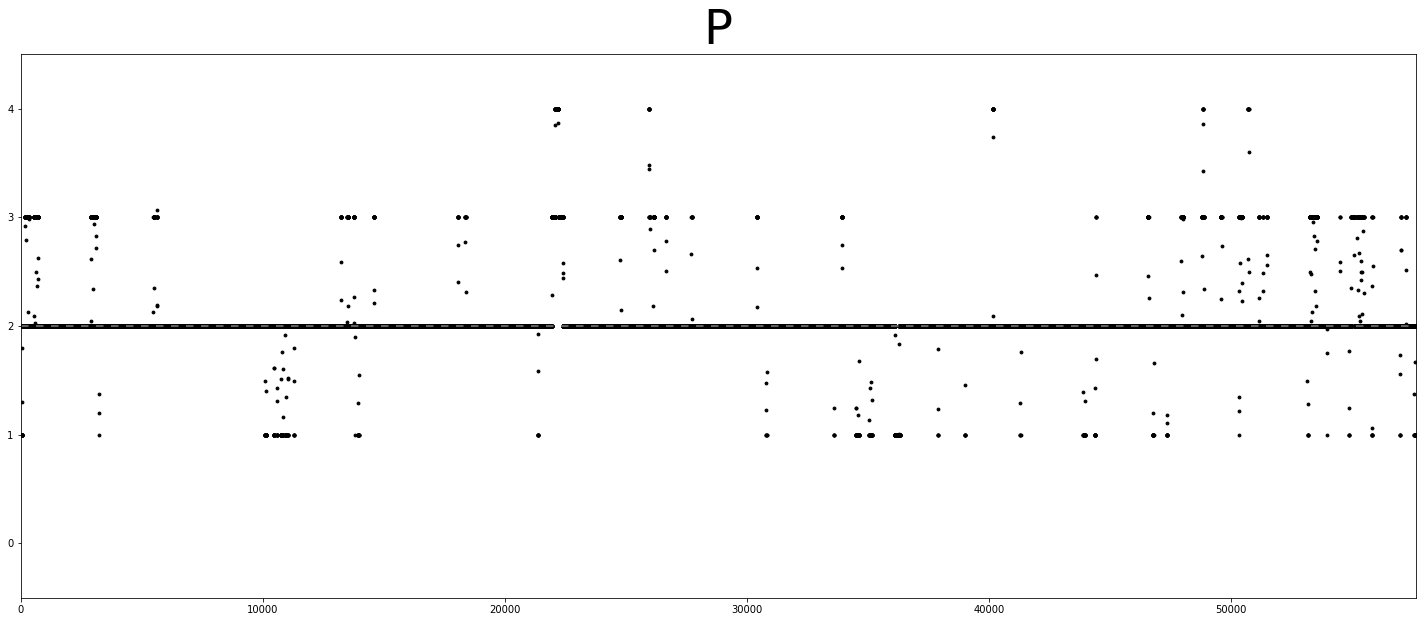

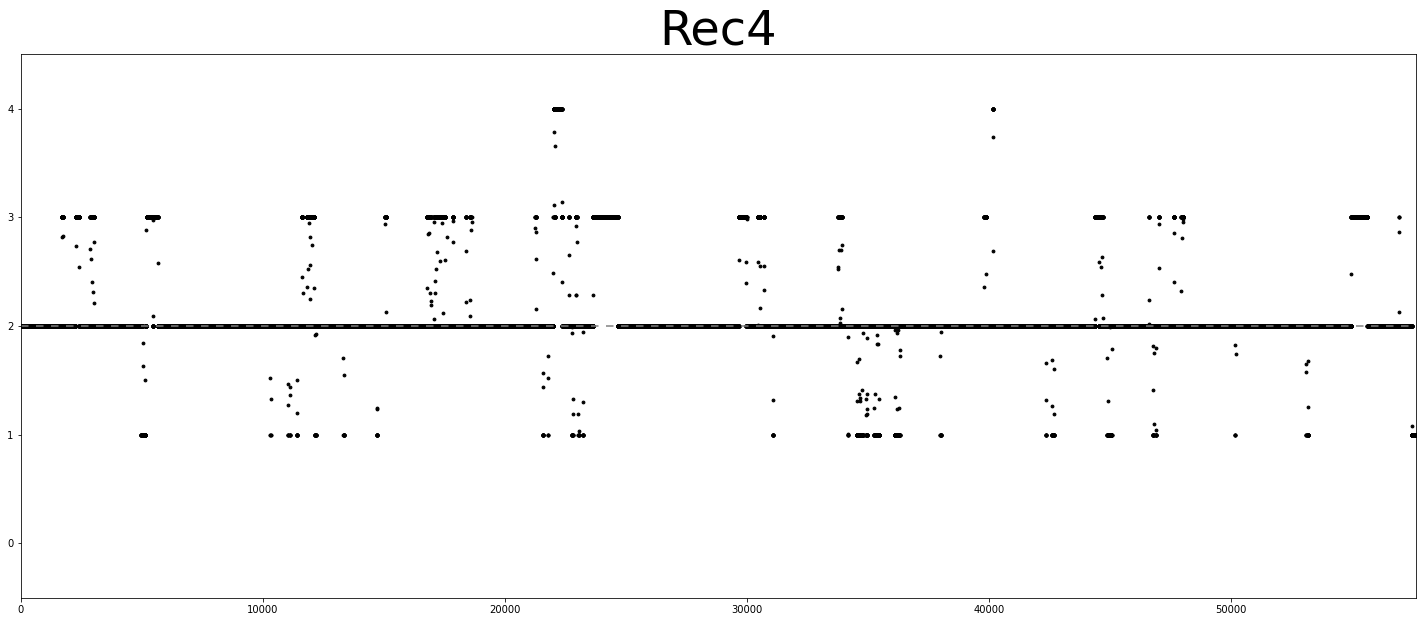

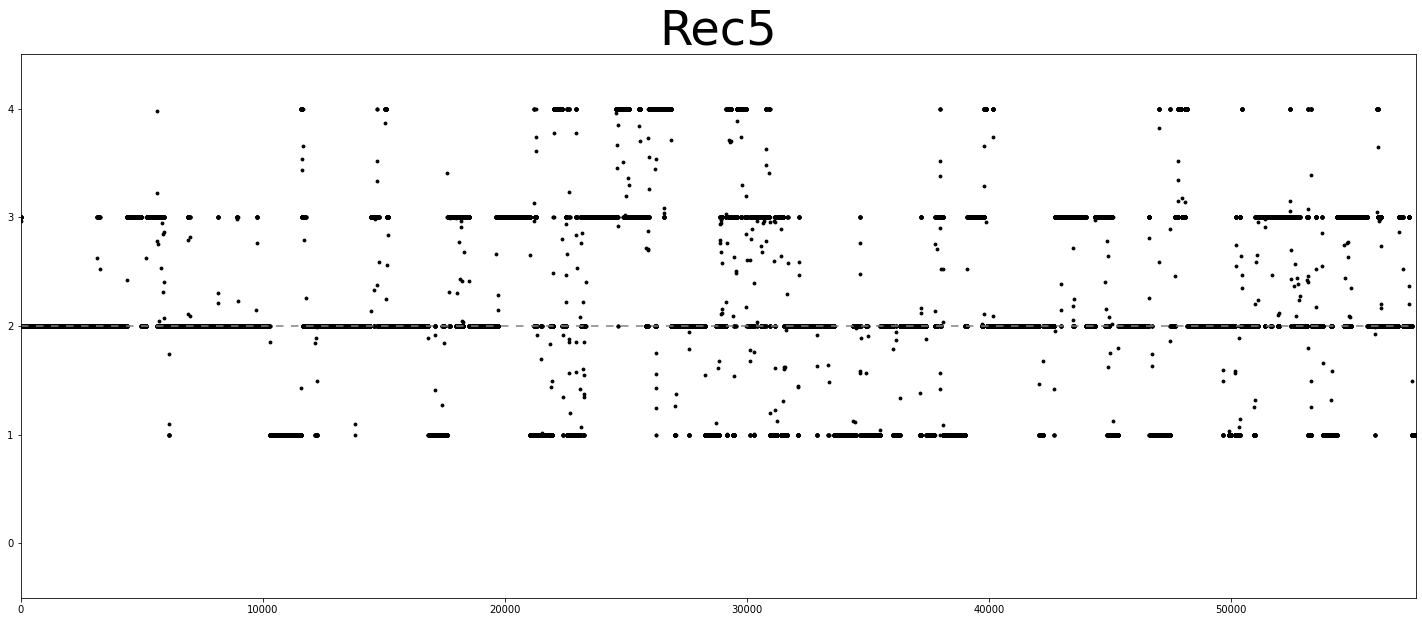

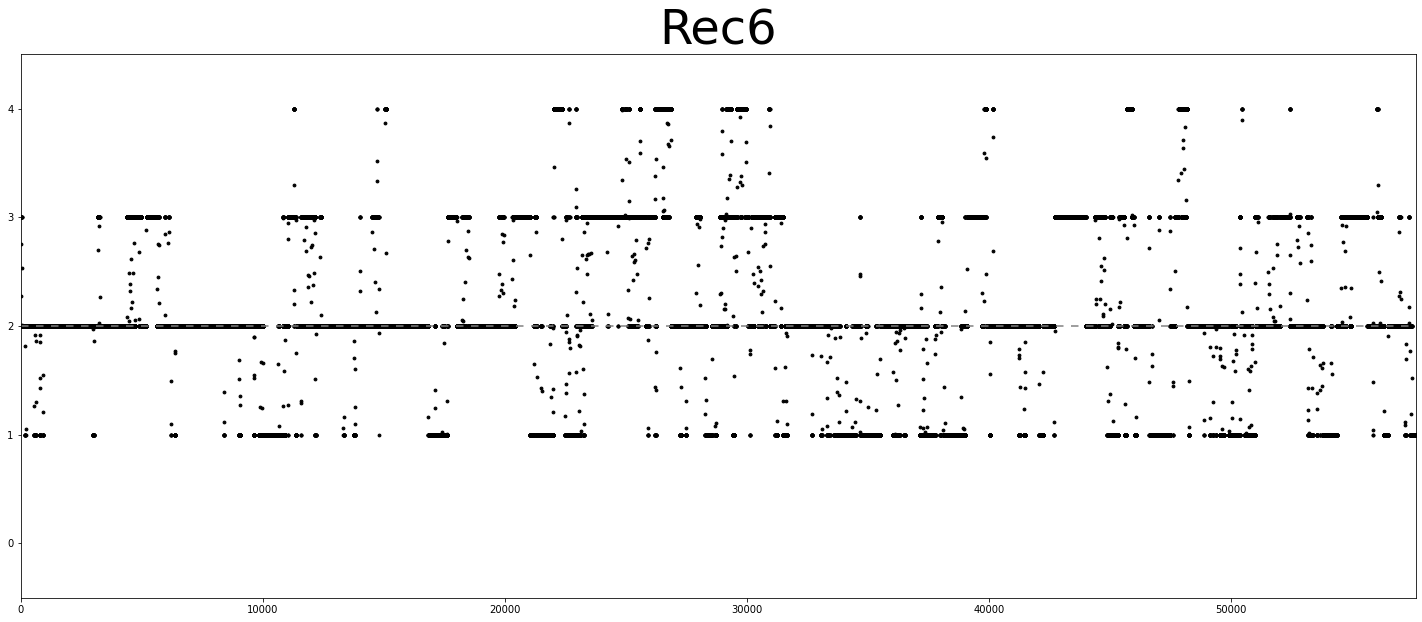

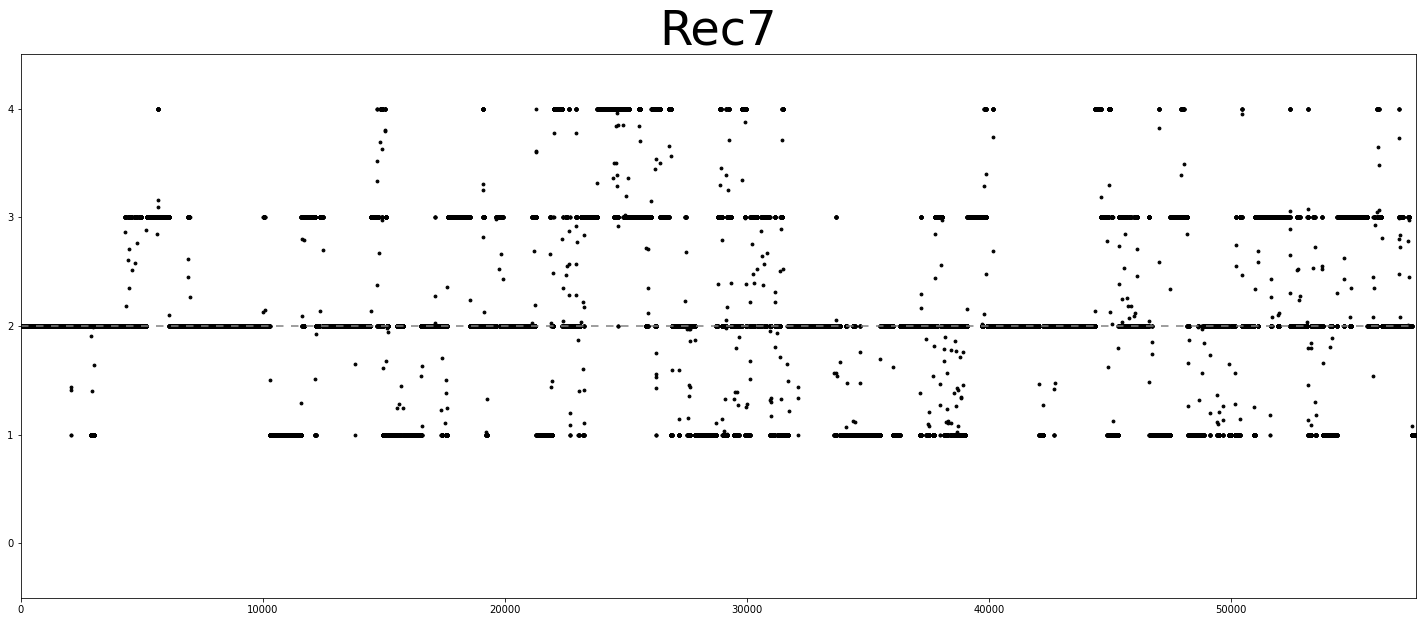

In [30]:
# scatter plot for every tumors genome
for i in range(len(flattened_tumors_bins)):
    scatter_bins(flattened_tumors_bins[i], title=tumors_names[i])

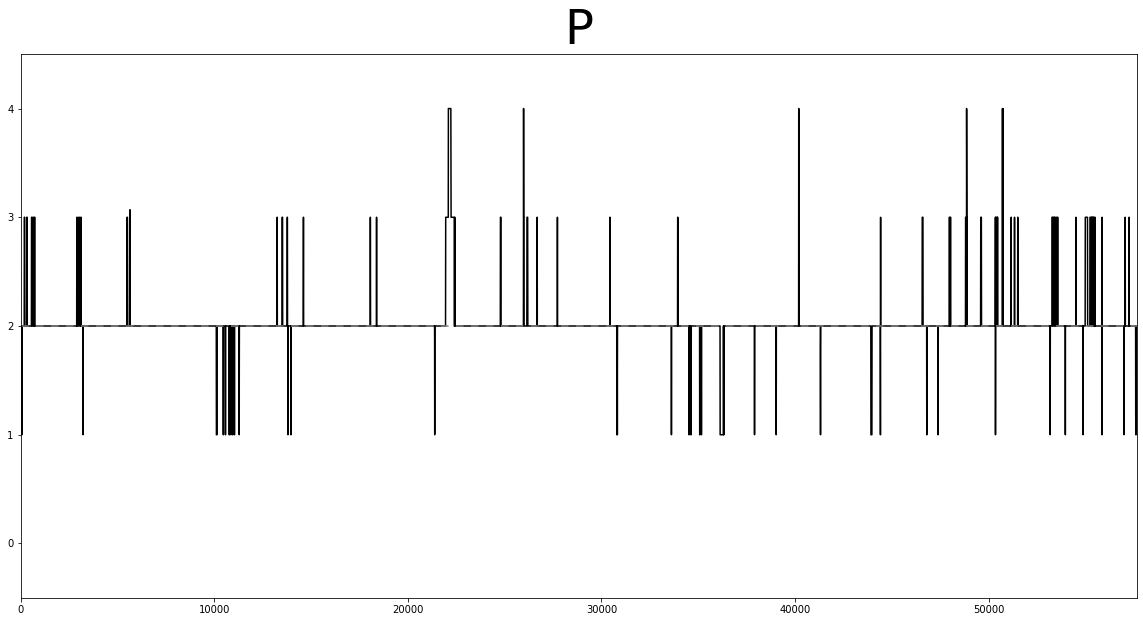

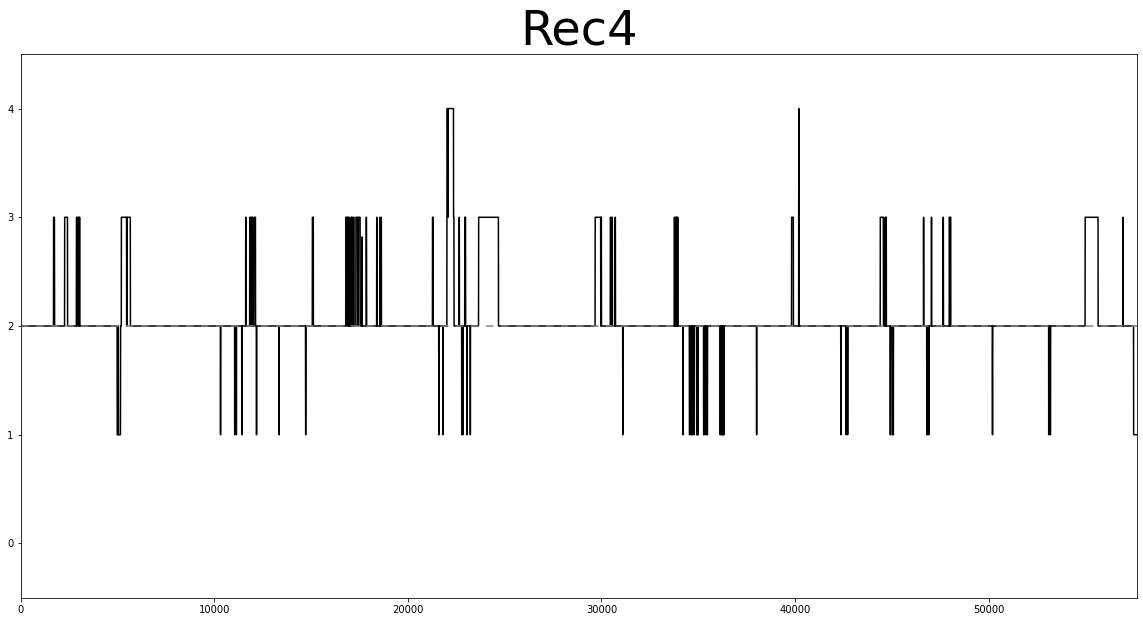

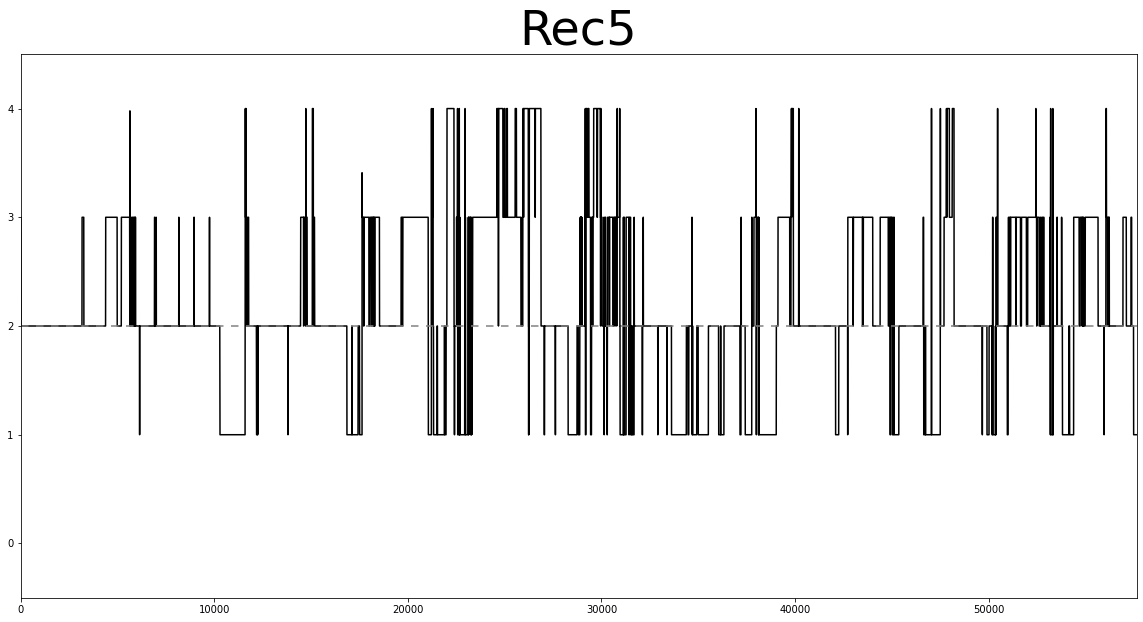

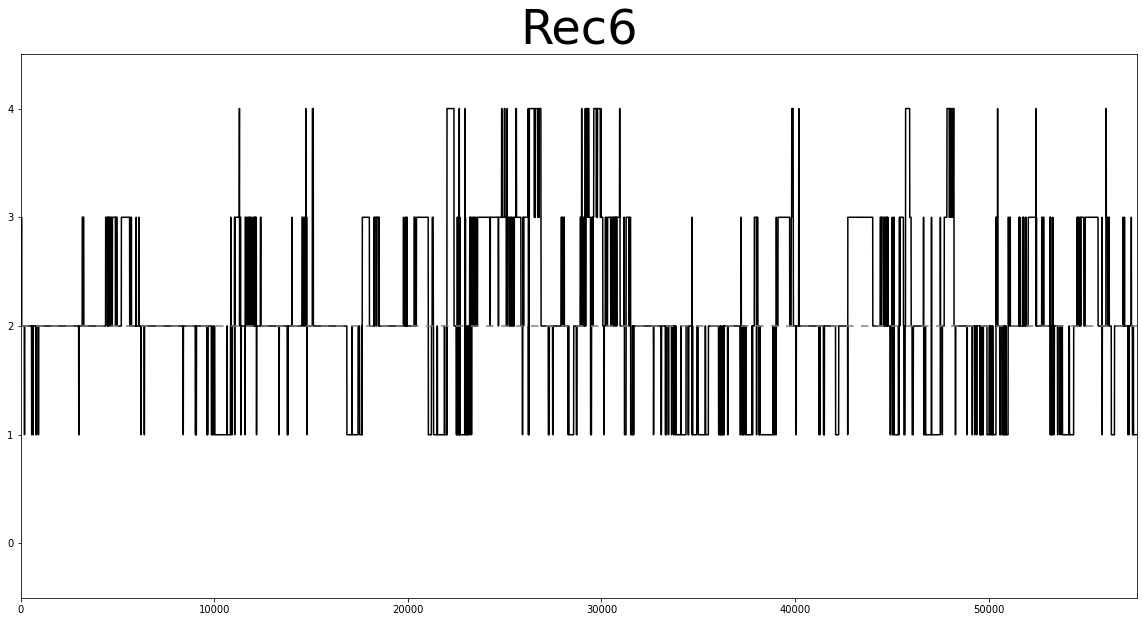

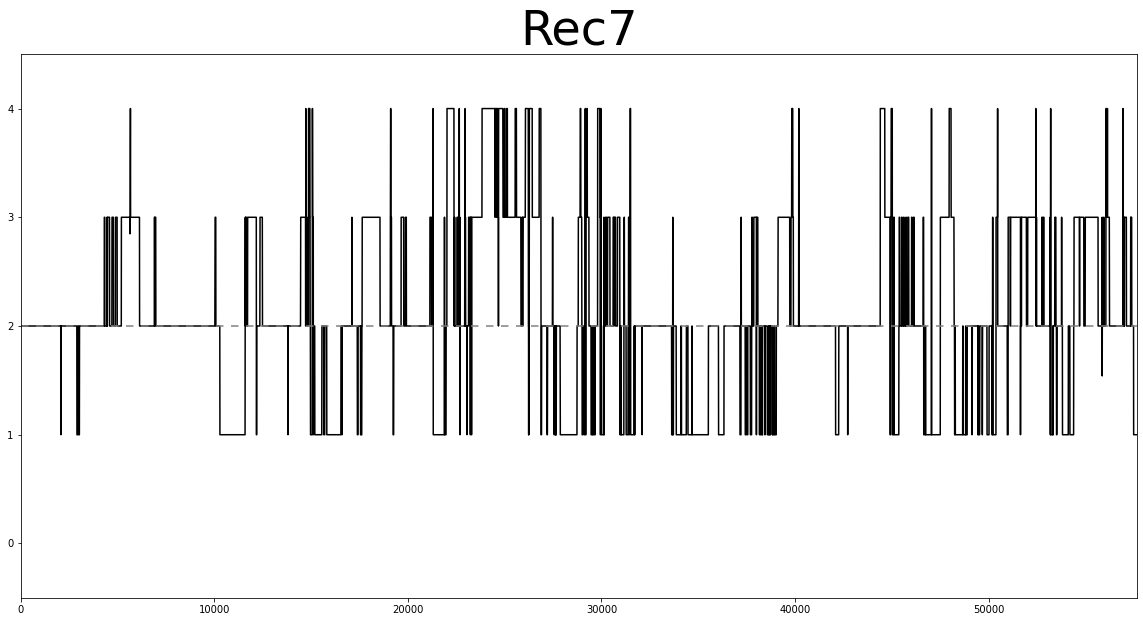

In [31]:
# plot bins of every tumors genome
for i in range(len(flattened_tumors_bins)):
    plot_bins(flattened_tumors_bins[i], title=tumors_names[i])

In [32]:
# count areas of every chromosome of every tumors genome
def count_tumors_areas(tumors_bins):
    tumors_areas = []
    for tumor_bins in tumors_bins:
        tumor_areas = count_genome_areas(tumor_bins)
        tumors_areas.append(tumor_areas)
        
    return tumors_areas

In [33]:
tumors_areas = count_tumors_areas(tumors_bins)

tumors_areas

[[235.6706,
  39.913940000000004,
  188.85428,
  28.79138,
  22.23224,
  600.9994,
  127.46628000000001,
  14.70332,
  11.46902,
  278.78818,
  11.517320000000002,
  34.785979999999995,
  56.29358,
  18.336660000000002,
  113.56274000000002,
  97.26512,
  146.00300000000001,
  6.2272,
  165.21148,
  267.34015999999997,
  13.8488,
  43.58412],
 [310.95026,
  613.54756,
  248.11294,
  428.59538,
  49.65512,
  1824.4082400000002,
  0.0,
  387.764,
  9.77094,
  351.56412,
  11.330939999999998,
  121.27092,
  30.28096,
  297.39724000000007,
  113.15713999999998,
  0.0,
  4.4299800000000005,
  23.84264,
  0.0,
  668.47776,
  0.0,
  159.91236],
 [701.54134,
  640.0220200000002,
  1522.1838200000002,
  1183.3563,
  2298.52148,
  3539.6495999999997,
  3325.6914800000004,
  2396.7298400000004,
  906.6032599999999,
  1833.51282,
  1554.42798,
  855.3900399999999,
  1422.21738,
  911.7663600000002,
  1658.91422,
  118.87894,
  841.4763999999999,
  978.5724000000001,
  706.5805799999999,
  1090.885

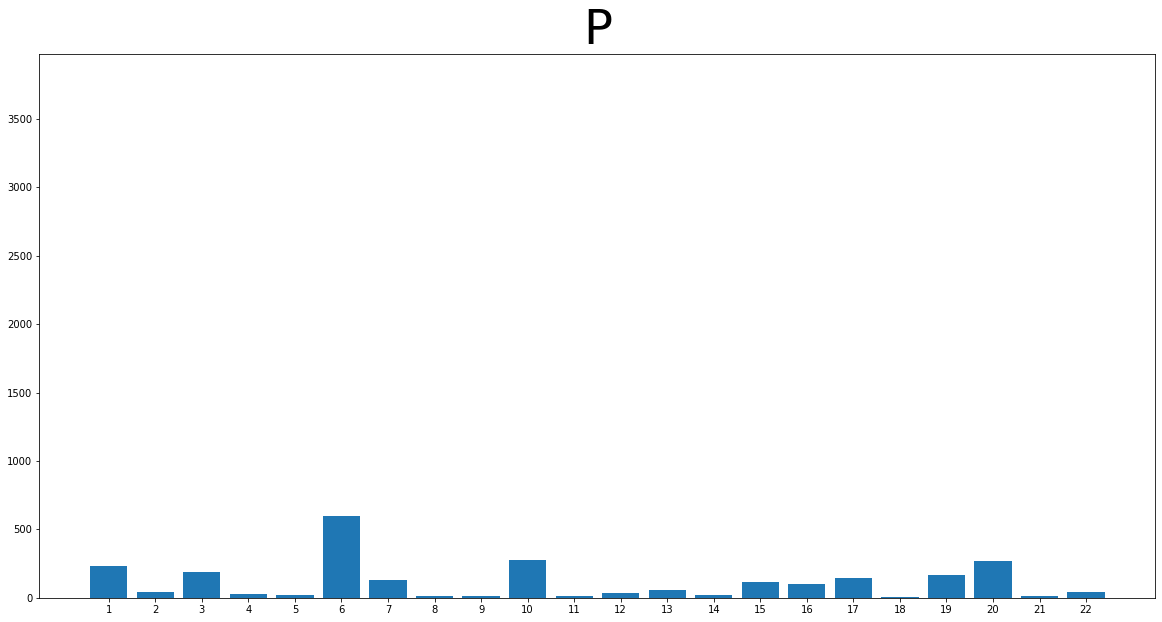

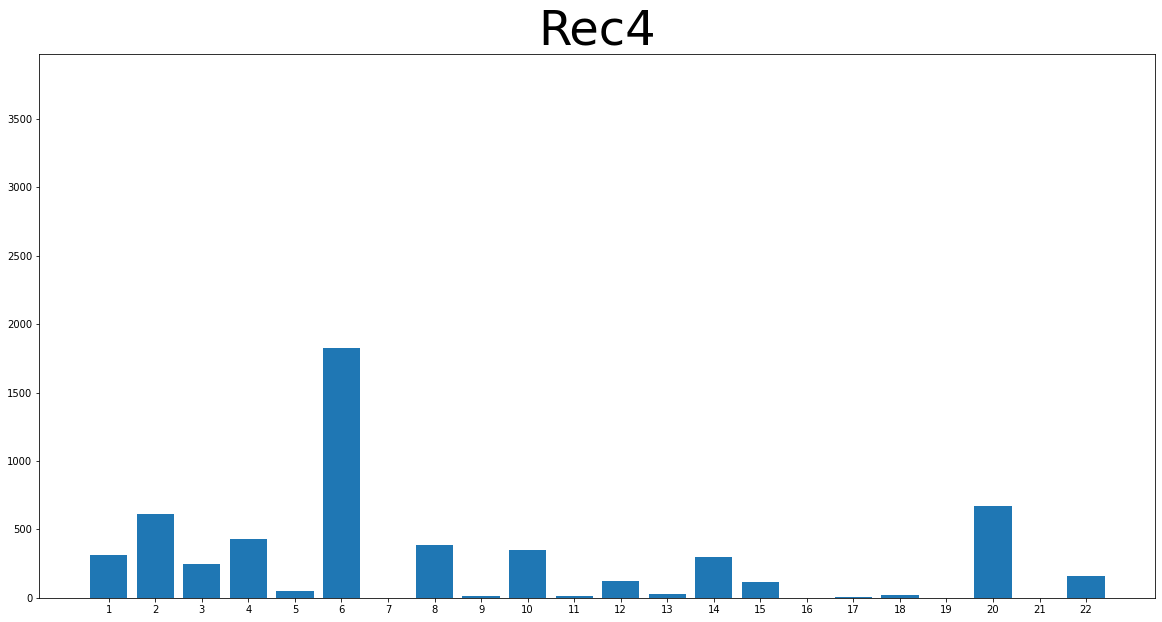

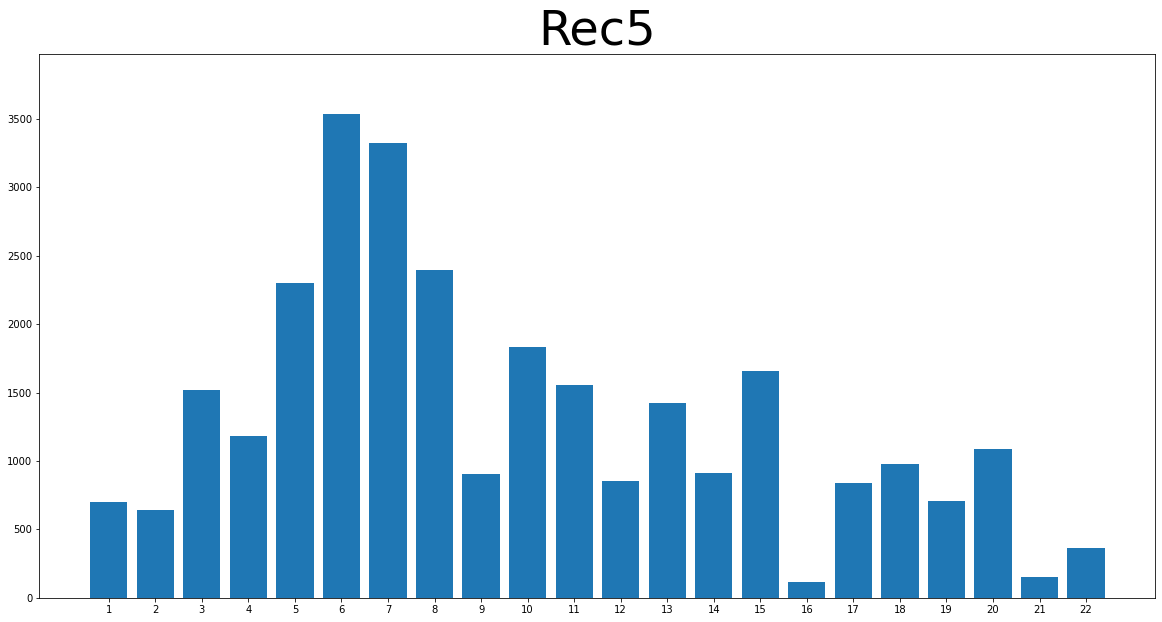

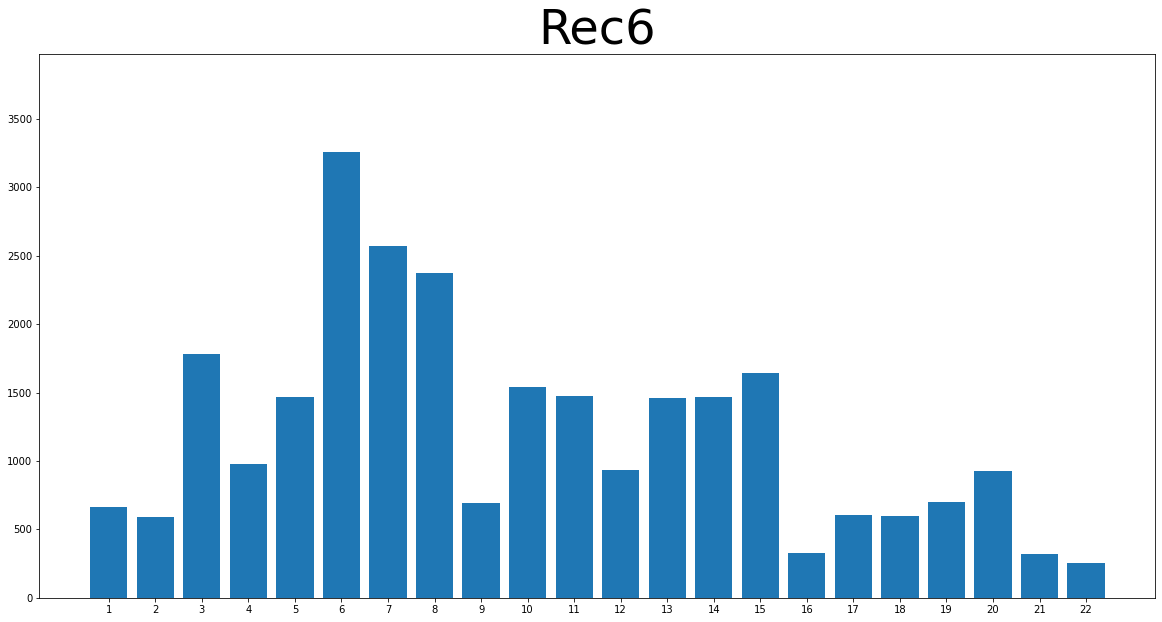

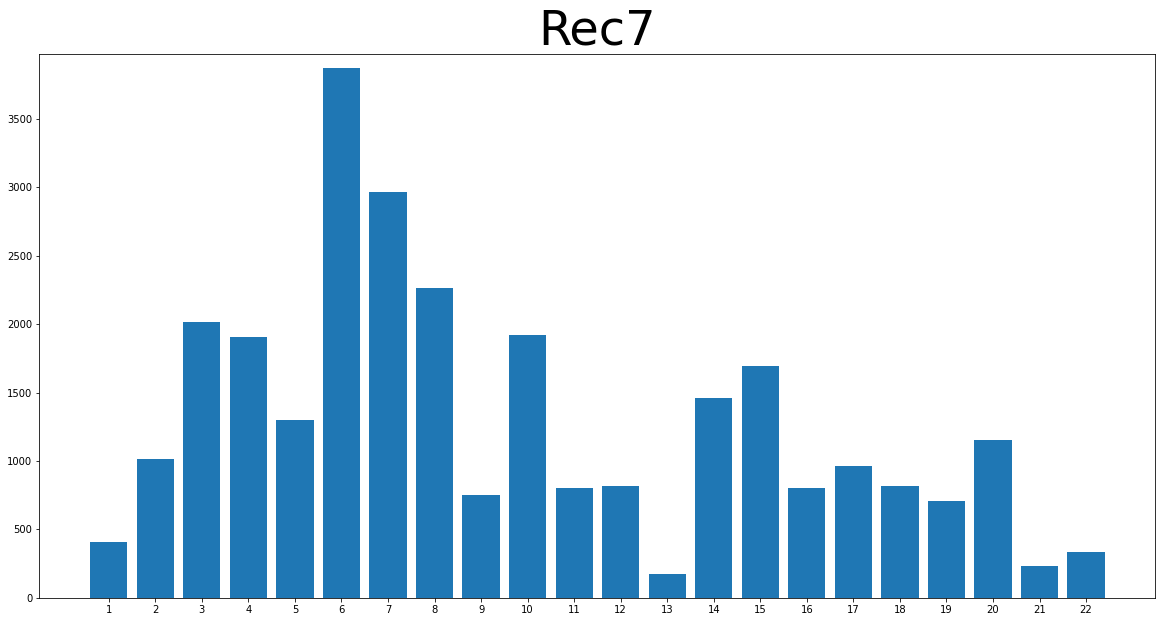

In [34]:
# visualizing areas of every single chromosome of every single tumor
for i in range(len(tumors_areas)):
    visualize_areas_bar(tumors_areas[i], title=tumors_names[i], ylim=[0, np.max(tumors_areas)+100])

In [35]:
def count_tumors_areas_sums(tumors_areas):
    areas_sums = []
    for tumor_areas in tumors_areas:
        tumor_area_sum = sum(tumor_areas)
        areas_sums.append(tumor_area_sum)
        
    return areas_sums

In [36]:
tumors_areas_sums = count_tumors_areas_sums(tumors_areas)
tumors_areas_sums

[2522.8648000000003,
 5654.468500000001,
 29000.203660000003,
 26611.48992,
 28373.175560000003]

In [37]:
def visualize_areas_sums(areas_sums):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.bar(tumors_names, areas_sums)
    ax.set_ylim([0, np.max(areas_sums) + 1000])

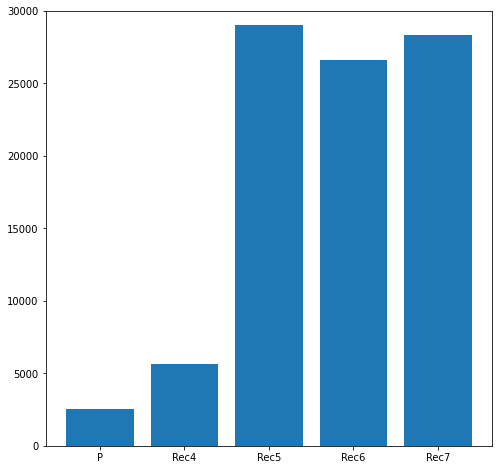

In [38]:
visualize_areas_sums(tumors_areas_sums)

In [39]:
# counting relative areas of every chromosome of every tumor
def count_tumors_relative_areas(tumors_areas, tumors_bins):
    tumors_relative_areas = []
    
    for idx, tumor_areas in enumerate(tumors_areas):
        tumor_relative_areas = count_relative_areas(tumor_areas, tumors_bins[idx])
        tumors_relative_areas.append(tumor_relative_areas)
        
    return tumors_relative_areas

In [40]:
tumors_relative_areas = count_tumors_relative_areas(tumors_areas, tumors_bins)
    
tumors_relative_areas

[[0.04726646610509427,
  0.008205990953947369,
  0.04767843473870235,
  0.007529126569037657,
  0.00614319977894446,
  0.175576803973123,
  0.04004595664467484,
  0.005021625683060109,
  0.004059830088495575,
  0.10283592032460347,
  0.004264094779711219,
  0.01298953696788648,
  0.024432977430555555,
  0.00854059618071728,
  0.05536944904924428,
  0.053797079646017695,
  0.08990332512315272,
  0.003986683738796415,
  0.13965467455621303,
  0.21200647105471845,
  0.014380893042575286,
  0.042438286270691336],
 [0.06236467308463699,
  0.1261405345394737,
  0.06263896490785155,
  0.11208038179916317,
  0.013720674219397622,
  0.532985170902717,
  0.0,
  0.13243306010928962,
  0.003458739823008849,
  0.12968060494282552,
  0.004195090707145501,
  0.04528413741598208,
  0.013142777777777778,
  0.13851757801583608,
  0.05517169185763041,
  0.0,
  0.0027278201970443354,
  0.015264174135723431,
  0.0,
  0.5301171768437748,
  0.0,
  0.1557082375851996],
 [0.14070223425591658,
  0.1315834745065

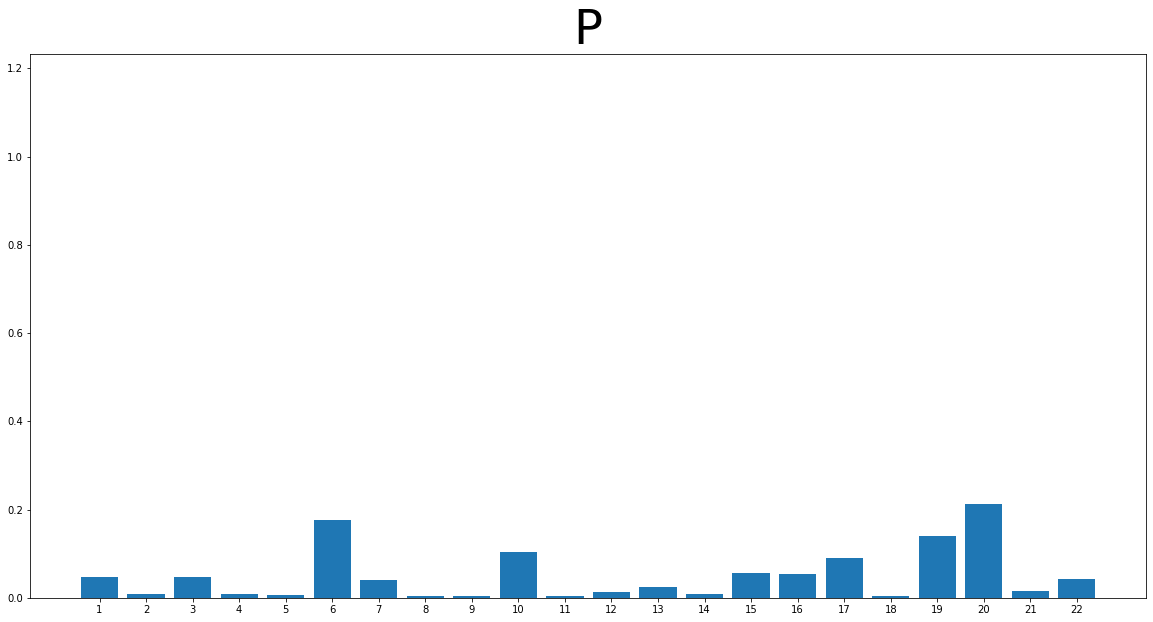

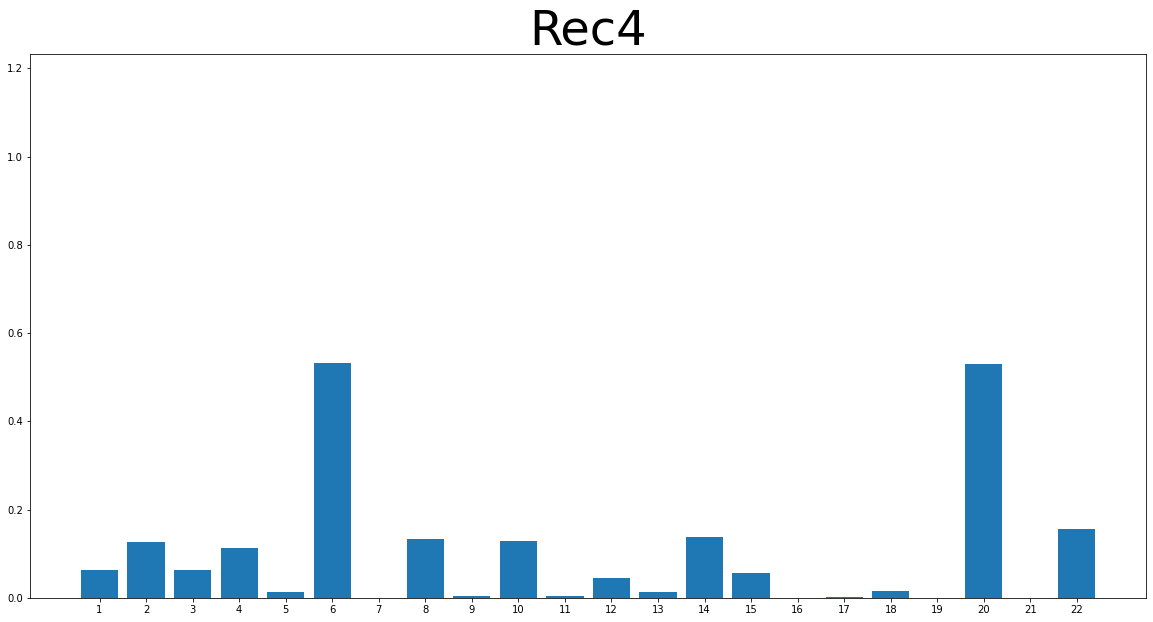

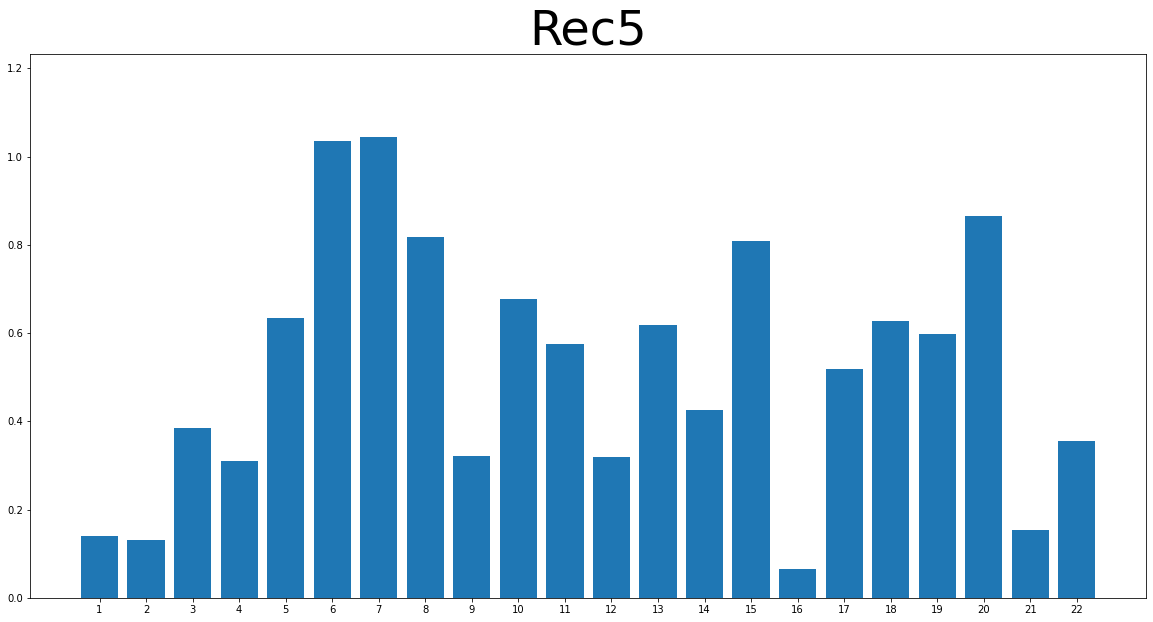

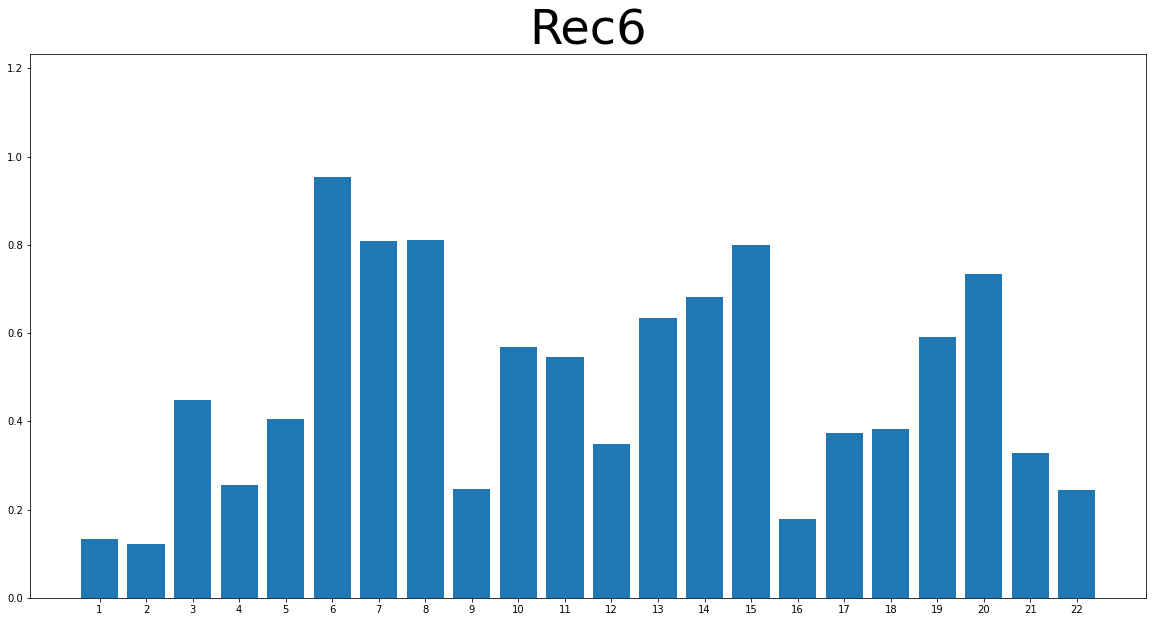

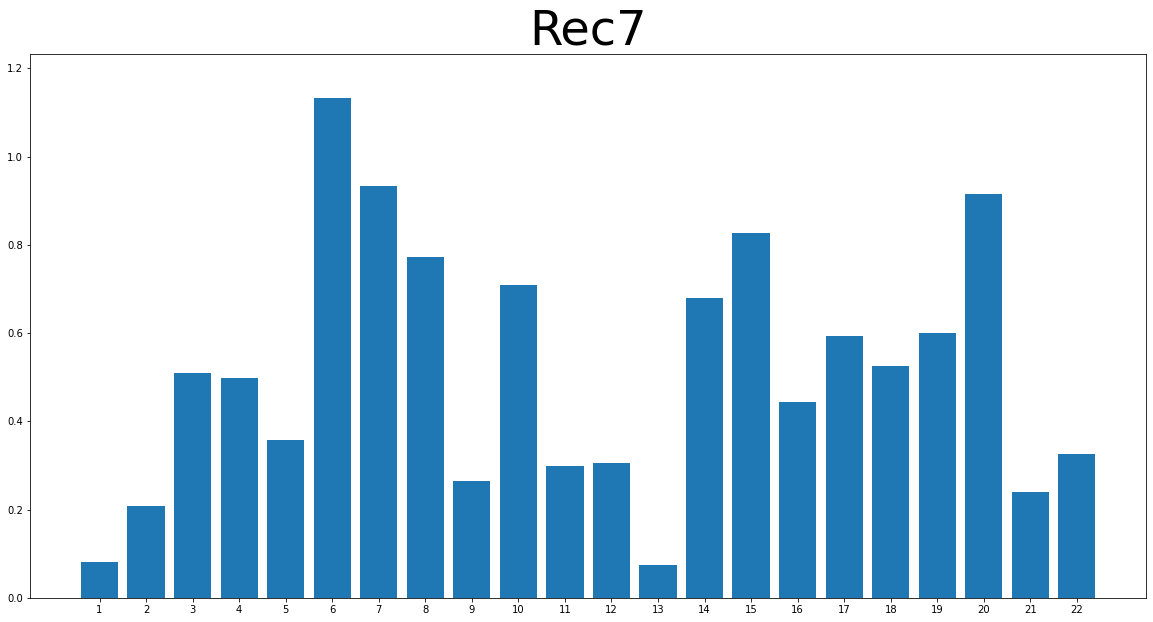

In [41]:
for i in range(len(tumors_relative_areas)):
    visualize_areas_bar(tumors_relative_areas[i], title=tumors_names[i], ylim=[0, np.max(tumors_relative_areas) + 0.1])

In [42]:
# count ratio of cnv on all tumors
def count_tumors_cnv_rates(tumors):
    cnv_rates = []
    for tumor in tumors:
        cnv_rate = count_cnv_rate(tumor)
        cnv_rates.append(cnv_rate)
        
    return cnv_rates

In [43]:
cnv_rates = count_tumors_cnv_rates(tumors)

cnv_rates

[0.08629928815076421,
 0.09254232656461299,
 0.45879986929335775,
 0.4249269565042134,
 0.4446553693431155]

In [44]:
# visualize and compare cnv of every tumor
def visualize_cnv_rates(cnv_rates):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.bar(tumors_names, cnv_rates)
    ax.set_ylim([0, 1])

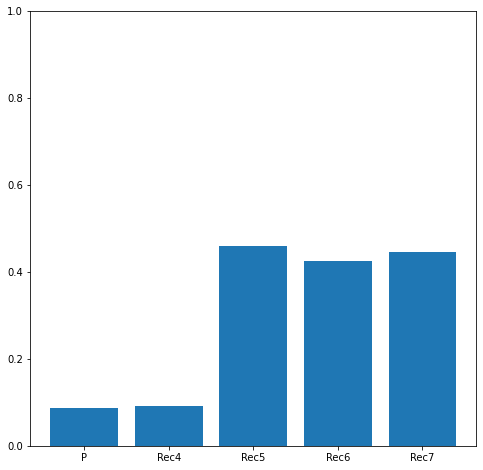

In [45]:
visualize_cnv_rates(cnv_rates)

In [56]:
def count_comparation_matrix(tumors_data, algorithm):
    matrix = {}

    for i in range(len(tumors_names)):
        for j in range(i+1, len(tumors_names)):
            data1 = tumors_data[i]
            data2 = tumors_data[j]

            tumor1_name = tumors_names[i]
            tumor2_name = tumors_names[j]
            
            matrix[(tumor2_name, tumor1_name)] = algorithm(data1, data2)
            
    return matrix

In [57]:
def comparation_matrix_to_df(data, algorithm):
    matrix = count_comparation_matrix(data, algorithm)
    series = pd.Series(list(matrix.values()),
                      index=pd.MultiIndex.from_tuples(matrix.keys()))
    df = series.unstack()
    
    return df

In [58]:
jaccard_matrix = count_comparation_matrix(tumors, jaccard)

jaccard_matrix

{('Rec4', 'P'): 0.906247682339561,
 ('Rec5', 'P'): 0.4571942828140876,
 ('Rec6', 'P'): 0.4940674298627473,
 ('Rec7', 'P'): 0.47236798045209183,
 ('Rec5', 'Rec4'): 0.46385285164136714,
 ('Rec6', 'Rec4'): 0.501068051265845,
 ('Rec7', 'Rec4'): 0.47916626548482427,
 ('Rec6', 'Rec5'): 0.9344737397215229,
 ('Rec7', 'Rec5'): 0.9405986006648664,
 ('Rec7', 'Rec6'): 0.9443805969292302}

In [59]:
jaccard_df = comparation_matrix_to_df(tumors, jaccard)

jaccard_df

,P,Rec4,Rec5,Rec6
Rec4,0.906248,NaN,NaN,NaN
Rec5,0.457194,0.463853,NaN,NaN
Rec6,0.494067,0.501068,0.934474,NaN
Rec7,0.472368,0.479166,0.940599,0.944381


Text(0.5, 1.0, 'Jaccard similarities')

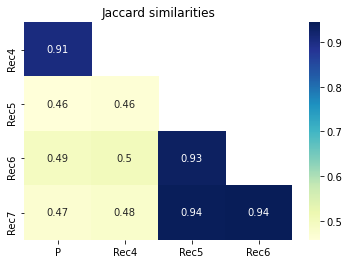

In [60]:
sns.heatmap(jaccard_df, cmap="YlGnBu", annot=True, mask=jaccard_df.isnull())
plt.title('Jaccard similarities')

In [62]:
count_comparation_matrix(flattened_tumors_bins, hamming)

{('Rec4', 'P'): 6200,
 ('Rec5', 'P'): 26358,
 ('Rec6', 'P'): 24639,
 ('Rec7', 'P'): 25403,
 ('Rec5', 'Rec4'): 24024,
 ('Rec6', 'Rec4'): 22186,
 ('Rec7', 'Rec4'): 24117,
 ('Rec6', 'Rec5'): 10131,
 ('Rec7', 'Rec5'): 15046,
 ('Rec7', 'Rec6'): 19257}

In [63]:
hamming_df = comparation_matrix_to_df(flattened_tumors_bins, hamming)

hamming_df

,P,Rec4,Rec5,Rec6
Rec4,6200.0,NaN,NaN,NaN
Rec5,26358.0,24024.0,NaN,NaN
Rec6,24639.0,22186.0,10131.0,NaN
Rec7,25403.0,24117.0,15046.0,19257.0


Text(0.5, 1.0, 'Hamming distances')

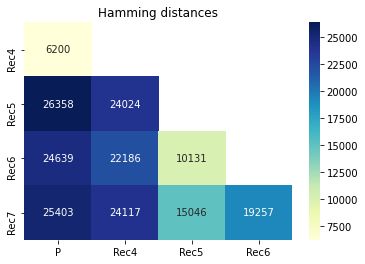

In [64]:
sns.heatmap(hamming_df, cmap="YlGnBu", annot=True, mask=hamming_df.isnull(), fmt='g')
plt.title('Hamming distances')

In [65]:
l1_df = comparation_matrix_to_df(flattened_tumors_bins, l1_distance)

l1_df

,P,Rec4,Rec5,Rec6
Rec4,6062.87382,NaN,NaN,NaN
Rec5,28552.72206,25948.75448,NaN,NaN
Rec6,26444.79664,23530.24770,10317.85002,NaN
Rec7,27723.45700,25219.95006,15526.02910,20360.69484


Text(0.5, 1.0, 'L1 distances')

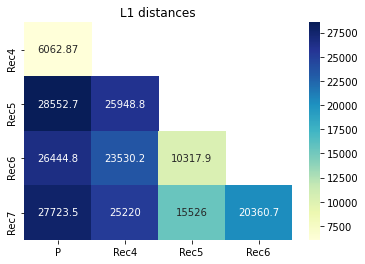

In [66]:
sns.heatmap(l1_df, cmap="YlGnBu", annot=True, mask=l1_df.isnull(), fmt='g')
plt.title('L1 distances')

In [67]:
l2_df = comparation_matrix_to_df(flattened_tumors_bins, l2_distance)

l2_df

,P,Rec4,Rec5,Rec6
Rec4,3041.118985,NaN,NaN,NaN
Rec5,16646.273488,15084.836807,NaN,NaN
Rec6,15289.094589,13380.276704,5678.066992,NaN
Rec7,16398.154237,13910.935087,8515.280076,11646.753443


Text(0.5, 1.0, 'L2 distances')

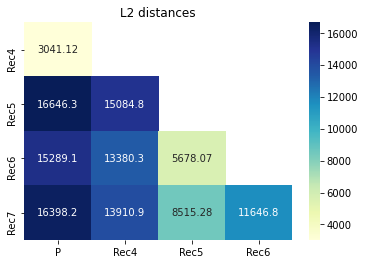

In [68]:
sns.heatmap(l2_df, cmap="YlGnBu", annot=True, mask=l2_df.isnull(), fmt='g')
plt.title('L2 distances')